In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class Env:

    def __init__(self,n,p):
        self.n=n
        self.p=p
        self.state=np.random.randint(0,n+1)
        self.done = self.state in (0,self.n)
        
    @property
    def capital(self):
        return self.state
        
    @property
    def actions(self):
        return range(min(self.state,self.n-self.state)+1)
    
    
    def reset(self):
        self.state=np.random.randint(0,self.n+1)
        self.done = self.state in (0,self.n)
        r=self.state==self.n
        return self.state,r,self.done

    def step(self,action):
        assert self.state+action <= self.n
        assert self.state-action >=0
        
        mul = 1-2*int(np.random.uniform(0,1)>self.p)
        
        self.state += mul*action
        
        self.done = self.state in (0,self.n)
        r=self.state==self.n
        
        return self.state,r,self.done
        



In [4]:
from tqdm import tqdm

In [5]:
class Qs:
    
    def __init__(self,n):
        self.n=n
        self.qs={i:np.zeros(min(i,self.n-i)+1) for i in range(self.n+1)}
        self.cs={i:np.zeros(min(i,self.n-i)+1) for i in range(self.n+1)}
        self.qs[100][0]=1
        
    def update(self,s,a,v):
        try:
            w=self.qs[s][a]
            c=self.cs[s][a]
        except IndexError:
            print(s,a)
            raise
        self.qs[s][a]=(w*c+v)/(c+1)
        self.cs[s][a]+=1

        
        

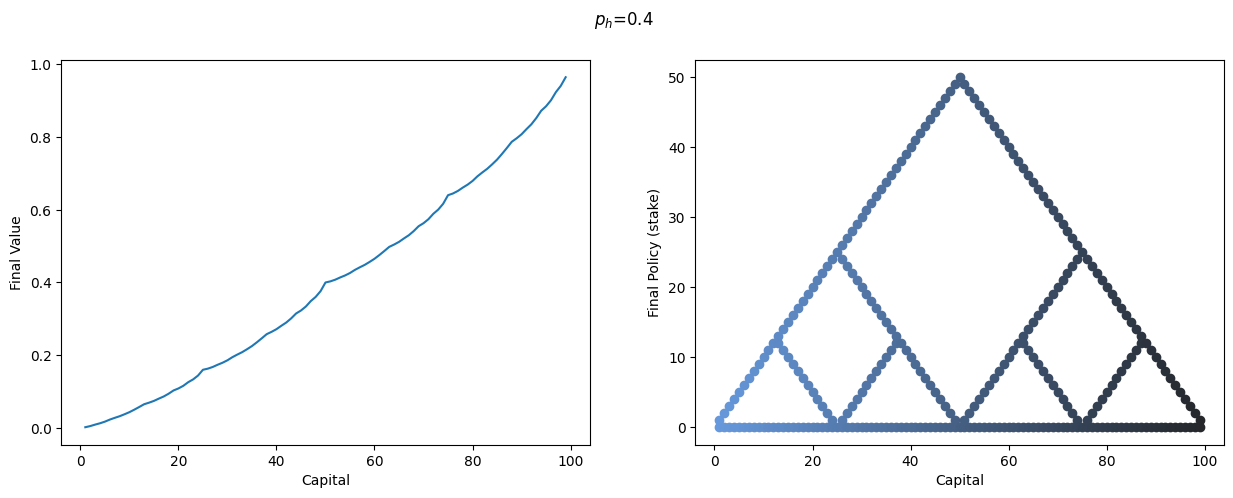

In [230]:
n=101
# state values
v=np.zeros(n)

# rewards
r=np.zeros(n)
r[n-1]=1.0

# probability of heads and tails
ph=.4
pt=(1-ph)

# discount factor
gamma=1

# threshold
theta=1e-15

for k in range(30000):
    delta=0.0
    for s in range(1,n-1):
        w=v[s]
        actions=np.array(range(min(s,n-1-s)+1))
        x=[ ph*r[s+a]+pt*r[s-a] + gamma*(ph*v[s+a]+pt*v[s-a]) for a in actions]
        v[s]=max(x)
        delta=max(delta,abs(w-v[s]))
    
    if delta < theta:
        break

_,axs=plt.subplots(1,2,figsize=(15,5))
axs[0].plot(range(1,n-1),v[1:-1])

cp=sns.dark_palette("#69d", n,reverse=True)
for s in range(1,n-1):
    actions=np.array(range(min(s,n-1-s)+1))
    x=[ ph*(r[s+a]+v[s+a])+pt*(r[s-a]+v[s-a]) for a in actions]
    allowed_actions=actions[np.isclose(x,np.max(x),rtol=1e-8)]
    axs[1].plot(s*np.ones(len(allowed_actions)),allowed_actions,"o",c=cp[s])
axs[0].set_xlabel('Capital')
axs[1].set_xlabel('Capital')
axs[0].set_ylabel('Final Value')
axs[1].set_ylabel('Final Policy (stake)')
plt.suptitle('$p_h$={}'.format(ph))
plt.show()

In [136]:
n=100
p=.4
epsilon=.1
qs=Qs(n)
env=Env(n,p)

all_paths=[]
all_vals=[]

In [137]:
for episode in tqdm(range(1000001)):
    states=[]
    actions=[]
    state,reward,done = env.reset()
    states.append(state)
    while not done:
        allowed_actions=np.array(list(env.actions))
        action_vals=qs.qs[state]
        if np.random.uniform()>epsilon/(1+episode/10000.0):
            #action=np.argmax(action_vals)
            max_val=np.max(action_vals)
            action=np.random.choice(allowed_actions[action_vals==max_val])
            #try:
            #    action=np.random.choice(range(len(action_vals)),p=action_vals/action_vals.sum())
            #except ValueError:
            #    action=np.random.choice(allowed_actions[1:])
        else:
            action=np.random.choice(allowed_actions)
        actions.append(action)
        state,reward,done=env.step(action)
        states.append(state)
    
    all_paths.append(list(states))
    # remove the terminal state
    s=states.pop()
    while states:
        s=states.pop()
        a=actions.pop()
        if True or s not in states:
            qs.update(s,a,reward)
    all_vals.append([np.max(qs.qs[i]) for i in range(101)])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [09:18<00:00, 1790.85it/s]


In [146]:
episode

1000000

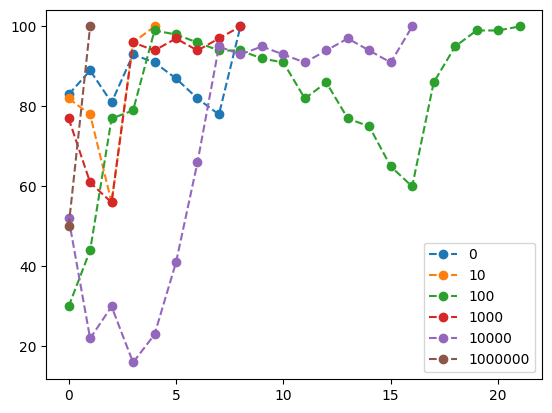

In [156]:
for k in (0,10,100,1000,10000,1000000):
    plt.plot(all_paths[k],'--o',label='{}'.format(k))
plt.legend()

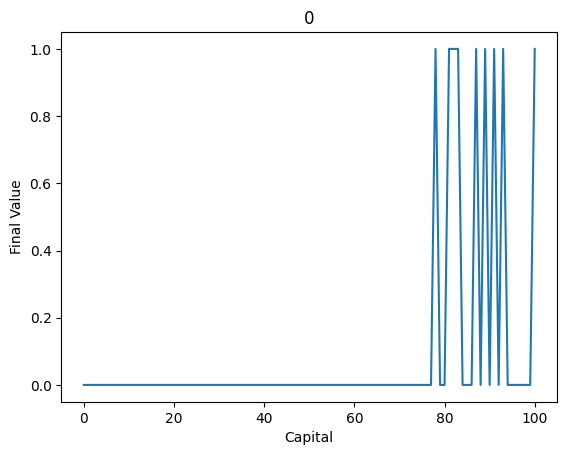

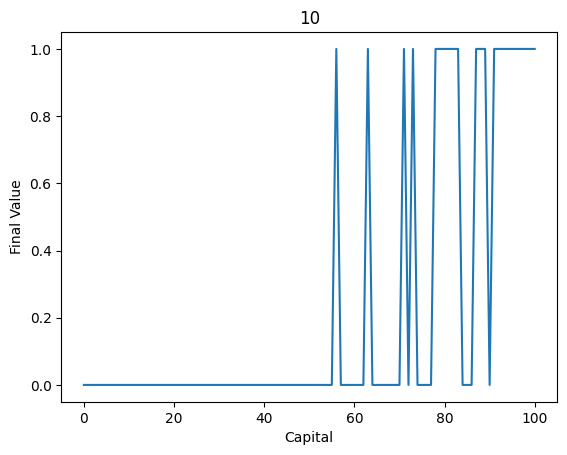

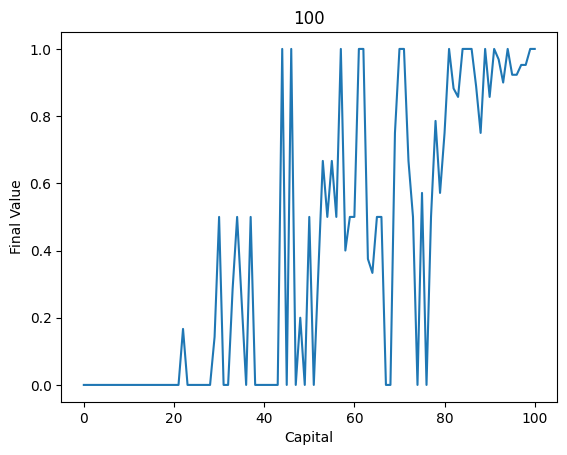

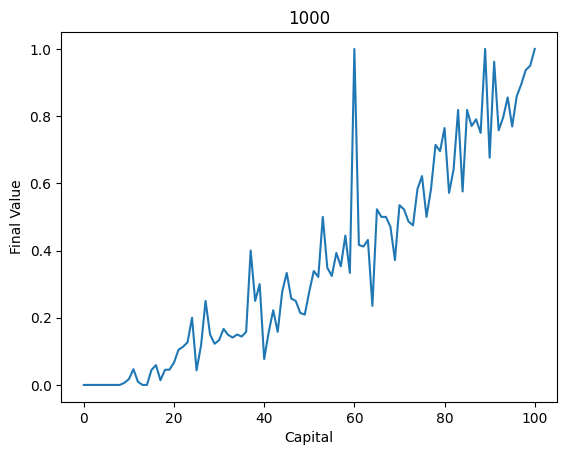

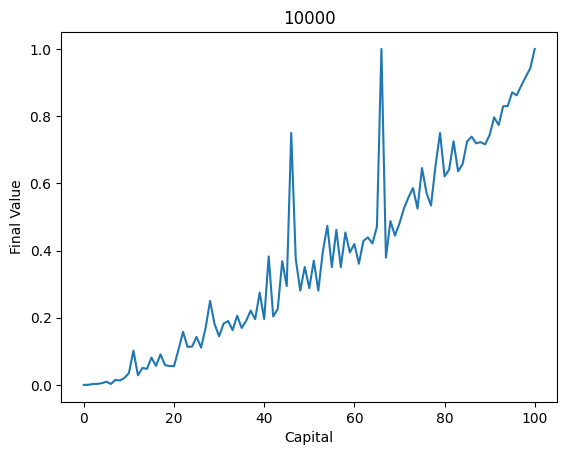

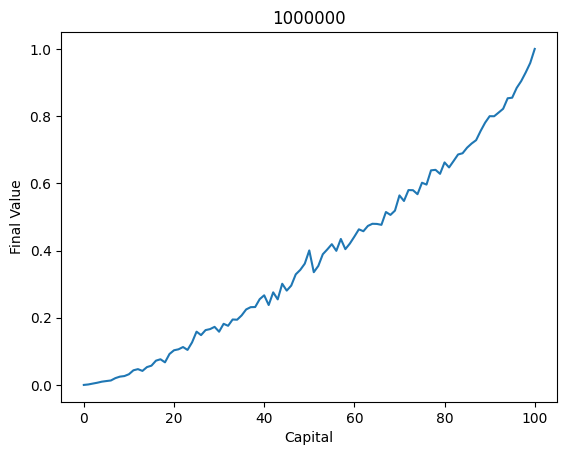

In [157]:
for k in (0,10,100,1000,10000,1000000):
    plt.plot(all_vals[k])
    plt.title(k)
    plt.xlabel('Capital')
    plt.ylabel('Final Value')
    plt.show()

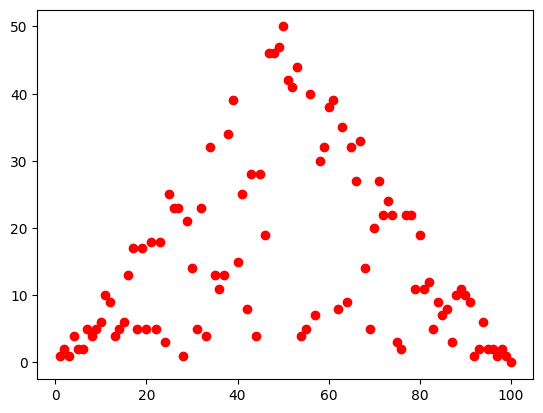

In [140]:
plt.plot(range(1,101),[np.argmax(qs.qs[i]) for i in range(1,101)],"ro")

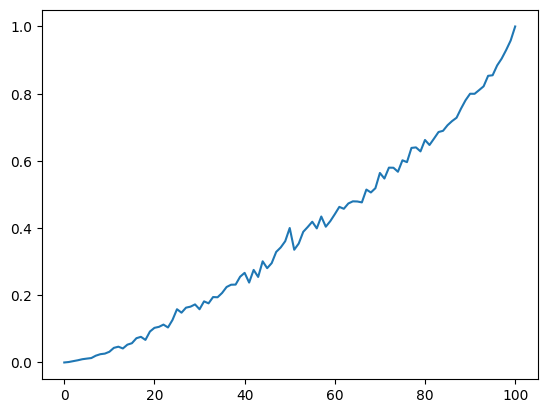

In [141]:
plt.plot([np.max(qs.qs[i]) for i in range(101)])

In [274]:
k=[]
for i in range(101):
    z=qs.qs[i]
    z/=z.sum()
    k.append(np.concatenate([z,np.ones(51-len(z))]))

/var/folders/_d/dlc5dt9d0yg5fxj9pxl1rs1w0000gn/T/ipykernel_39780/432064847.py:4: RuntimeWarning: invalid value encountered in divide
  z/=z.sum()


<AxesSubplot: >

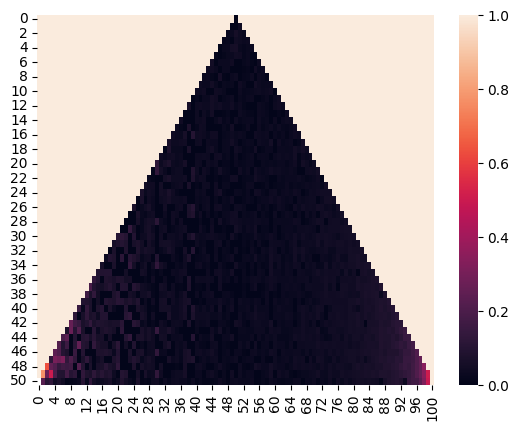

In [275]:
import seaborn as sns
sns.heatmap(np.stack(k).T[::-1])

In [161]:
n=100
p=.4
epsilon=.1
qs=Qs(n)
env=Env(n,p)

for episode in tqdm(range(100000)):
    states=[]
    actions=[]
    state,reward,done = env.reset()
    if not done:
        states.append(state)
    while not done:
        allowed_actions=list(env.actions)
        action_vals=qs.qs[state]
        if np.random.uniform()>epsilon/(1+episode/1000000000.0):
            action=np.argmax(action_vals)
            #try:
            #    action=np.random.choice(range(len(action_vals)),p=action_vals/action_vals.sum())
            #except ValueError:
            #    action=np.random.choice(allowed_actions[1:])
        else:
            action=np.random.choice(allowed_actions)
        actions.append(action)
        state,reward,done=env.step(action)
        if not done:
            states.append(state)
    c=0
    while states:
        s=states.pop()
        a=actions.pop()
        if True or s not in states:
            if reward==0:
                qs.update(s,a,reward)
            elif c==0:
                qs.update(s,a,reward)
            else:
                qs.update(s,a,0)
        c+=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:37<00:00, 1023.56it/s]


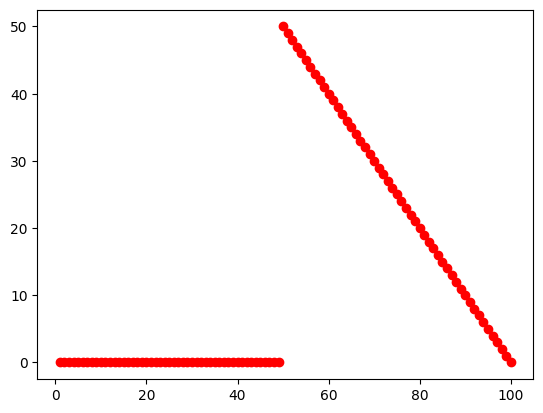

In [162]:
plt.plot(range(1,101),[np.argmax(qs.qs[i]) for i in range(1,101)],"ro")

Text(0, 0.5, 'Final Value')

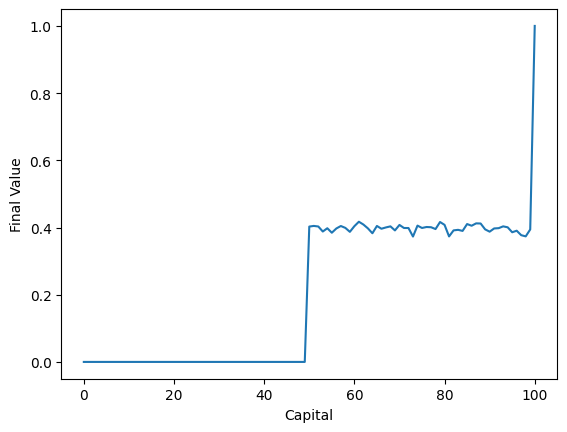

In [163]:
plt.plot([np.max(qs.qs[i]) for i in range(101)])
plt.xlabel('Capital')
plt.ylabel('Final Value')